In [320]:
#install packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import matplotlib
import wordcloud #conda install -c conda-forge wordcloud=1.2.1 
from wordcloud import WordCloud, STOPWORDS
import numpy as np

In [321]:
fedcentral_users = pd.read_csv('Fedcentral_users.csv')
federations = pd.read_csv('federations.csv')   
assets = pd.read_csv('Fedcentral_Assets.csv') 
assets['ID'] =  assets['ID'].str.replace('https://fedcentral.org/assets/view/','')


federations = federations[(federations['code']=='60600') | (federations['code']=='60450') |
                          (federations['code']=='60717') | (federations['code']=='60820') |
                          (federations['code']=='60536') | (federations['code']=='60050') |
                          (federations['code']=='60115') | (federations['code']=='60280') |
                          (federations['code']=='60222') | (federations['code']=='60335') | 
                          (federations['code']=='60780')]
 
fedcentral_users['Date Joined'] = fedcentral_users['Date Joined'].str.split(' ',expand=True)[0]
fedcentral_users['Last Login'] = fedcentral_users['Last Login'].str.split(' ',expand=True)[0]
fedcentral_users['Date Joined'].fillna('2013/12/31',inplace=True)
fedcentral_users['Date Joined'] = pd.to_datetime(fedcentral_users['Date Joined'])
fedcentral_users['Last Login'] = pd.to_datetime(fedcentral_users['Last Login'])
fedcentral_users_by_federation = pd.merge(fedcentral_users, federations[['name','code']], how='inner',left_on = 'Federation', right_on = 'name')

In [322]:
total_users = len(set(fedcentral_users_by_federation))

fedcentral_users_growth_rate = fedcentral_users_by_federation[['Email','Date Joined']]
fedcentral_users_by_federation.set_index('Date Joined')
fedcentral_users_growth_rate.set_index('Date Joined',inplace=True)

In [323]:
fedcentral_users_growth_cumsum = pd.DataFrame(fedcentral_users_growth_rate.resample('Y')['Email'].count())
fedcentral_users_growth_cumsum.columns=['# New Users']
fedcentral_users_growth_cumsum['Year'] = ['2013','2014','2015','2016','2017','2018','2019']
fedcentral_users_growth_cumsum['Total Users'] = fedcentral_users_growth_cumsum['# New Users'].cumsum().values
fedcentral_users_growth_cumsum.reset_index(inplace=True)
fedcentral_users_growth_cumsum[['Year','# New Users','Total Users']]
fedcentral_users_growth_cumsum['% change'] = round(fedcentral_users_growth_cumsum['Total Users'].pct_change()*100,2)
fedcentral_users_growth_cumsum.loc[2,'# New Users'] = fedcentral_users_growth_cumsum.loc[0:2,'# New Users'].sum() 
#fedcentral_users_growth_cumsum.drop(['Date Joined'],axis=1,inplace=True)
#fedcentral_users_growth_cumsum.drop(fedcentral_users_growth_cumsum.index[0:2],inplace=True)
fedcentral_users_growth_cumsum[['Year','# New Users','Total Users','% change']]

,Year,# New Users,Total Users,% change
0,2013,45,45,NaN
1,2014,5,50,11.11
2,2015,56,56,12.00
3,2016,87,143,155.36
4,2017,44,187,30.77
5,2018,30,217,16.04
6,2019,10,227,4.61


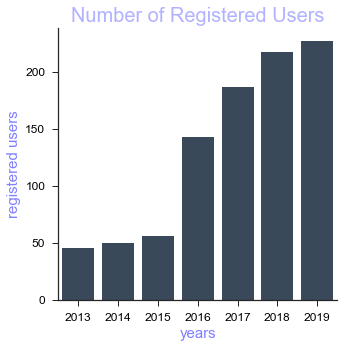

In [324]:
sns.set(style="ticks")

flatui = ["#34495e"]

# This Function takes as input a custom palette
g = sns.barplot(x='Year', y='Total Users', palette=sns.color_palette(flatui),data=fedcentral_users_growth_cumsum,ci=None)

flatui = ["#34495a"]

# remove the top and right line in graph
sns.despine()

# Set the size of the graph from here
g.figure.set_size_inches(5,5)
# Set the Title of the graph from here
g.axes.set_title('Number of Registered Users',
    fontsize=20,color="b",alpha=0.3)
# Set the xlabel of the graph from here
g.set_xlabel("years",size = 15,color="b",alpha=0.5)
# Set the ylabel of the graph from here
g.set_ylabel("registered users",size = 15,color="b",alpha=0.5)
# Set the ticklabel size and color of the graph from here
g.tick_params(labelsize=12,labelcolor="black")

In [325]:
members_bloomfire = pd.read_csv('bloomfire_members.csv')
members_bloomfire = pd.merge(members_bloomfire, fedcentral_users[['Email','Federation']], how='left',on = 'Email')
members_bloomfire = pd.merge(members_bloomfire, federations[['name','code']], how='inner',left_on = 'Federation', right_on = 'name')

members_bloomfire_2018 = pd.read_csv('bloomfire_members_2018.csv')
members_bloomfire_2018 = pd.merge(members_bloomfire_2018, fedcentral_users[['Email','Federation']], how='left',on = 'Email')
members_bloomfire_2018 = pd.merge(members_bloomfire_2018, federations[['name','code']], how='inner',left_on = 'Federation', right_on = 'name')


active_users_fedweb_bloomfire = pd.DataFrame()
active_users_fedweb_bloomfire['platform'] = ['FedCentral (views + downloads + searches)','Bloomfire','FedCentral + Bloomfire']
fedweb_active = set(fedcentral_users_by_federation[fedcentral_users_by_federation['Last Login'] < '05/31/2019']['Email'].str.lower())
active_bloom = set(members_bloomfire['Email'].str.lower())
active_users_fedweb_bloomfire['# active users'] = [len(fedweb_active),
                                             len(active_bloom),
                                             len(set(active_bloom.union(fedweb_active)))]
active_users_fedweb_bloomfire['% registered'] = [len(fedweb_active)/len(fedcentral_users_by_federation),
                                                 len(active_bloom)/len(fedcentral_users_by_federation),
                                                 len(active_bloom.union(fedweb_active))/len(fedcentral_users_by_federation)]  
active_users_fedweb_bloomfire['% registered'] = round(active_users_fedweb_bloomfire['% registered']*100,2)

fedweb_active_past = set(fedcentral_users_by_federation[(fedcentral_users_by_federation['Last Login'] > '05/31/2018') & (fedcentral_users_by_federation['Last Login'] < '05/31/2019')]['Email'].str.lower())

active_users_fedweb_bloomfire['# active users past year'] = [len(fedweb_active_past),
                                             len(set(members_bloomfire_2018['Email'])),
                                             len(set(set(members_bloomfire_2018['Email']).union(fedweb_active_past)))]

active_users_fedweb_bloomfire['# active users past year'] = [len(fedweb_active_past),
                                             len(set(members_bloomfire_2018['Email'])),
                                             len(set(set(members_bloomfire_2018['Email']).union(fedweb_active_past)))]

active_users_fedweb_bloomfire['% registered past year'] = [len(fedweb_active_past)/len(fedcentral_users_by_federation),
                                                 len(members_bloomfire_2018)/len(fedcentral_users_by_federation),
                                                 len(set(set(members_bloomfire_2018['Email']).union(fedweb_active_past)))/len(fedcentral_users_by_federation)]  
active_users_fedweb_bloomfire['% registered past year'] = round(active_users_fedweb_bloomfire['% registered past year']*100,2)


active_users_fedweb_bloomfire

,platform,# active users,% registered,# active users past year,% registered past year
0,FedCentral (views + downloads + searches),216,95.15,78,34.36
1,Bloomfire,114,50.22,61,26.87
2,FedCentral + Bloomfire,218,96.04,104,45.81


In [326]:
active_users_fedcentral = pd.DataFrame()
active_users_fedcentral['Time Period'] = ['Daily','Weekly','Monthly']


assets_down_fed = pd.read_csv('assets_down_fed.csv')
assets_down_fed2 = pd.read_csv('assets_down_fed2.csv')
assets_down_fed3 = pd.read_csv('assets_down_fed3.csv')
assets_down_fed4 = pd.read_csv('assets_down_fed4.csv')
assets_down_fed5 = pd.read_csv('assets_down_fed5.csv')
assets_down_fed6 = pd.read_csv('assets_down_fed6.csv')
assets_down_fed7 = pd.read_csv('assets_down_fed7.csv')
assets_down_fed8 = pd.read_csv('assets_down_fed8.csv')
assets_down_fed9 = pd.read_csv('assets_down_fed9.csv')

pac_down_fed = pd.read_csv('pac_down_fed.csv')
pac_down_fed['type']='package'

assets_down_fed = pd.concat([assets_down_fed,assets_down_fed2,assets_down_fed3,assets_down_fed4,
                        assets_down_fed5,assets_down_fed6,assets_down_fed7,assets_down_fed8, assets_down_fed9])


assets_down_fed = assets_down_fed[assets_down_fed['User Organization']!='JFNA']
pac_down_fed = pac_down_fed[pac_down_fed['User Organization']!='JFNA']

assets_down_fed['User Organization'] = pd.to_numeric(assets_down_fed['User Organization'])
pac_down_fed['User Organization'] = pd.to_numeric(pac_down_fed['User Organization'])

federations['code'] = pd.to_numeric(federations['code'])
assets['ID'] = pd.to_numeric(assets['ID'])
assets_down_fed = pd.merge(assets_down_fed,federations[['code','name']],how='inner',left_on = 'User Organization', right_on = 'code')
assets_down_fed = pd.merge(assets_down_fed,assets[['ID','type']],how='inner',left_on = 'Event Label', right_on = 'ID')


pac_down_fed = pd.merge(pac_down_fed,federations[['code','name']],how='inner',left_on = 'User Organization', right_on = 'code')

assets_down_fed = pd.concat([assets_down_fed,pac_down_fed],sort=True)

x=pd.DataFrame(assets_down_fed.groupby(['name','type'])['Total Events'].sum())
x

Total Events
name                                   type                  
Atlantic Jewish Council                design              10
                                       document            17
                                       package              1
                                       photo               50
Calgary Jewish Federation              design              21
                                       document            31
                                       package              9
                                       photo              190
                                       video               22
Federation CJA                         audio                1
                                       design              67
                                       document           142
                                       package             66
                                       photo              832
                                       video                5
Jewish Federation of Edmonton          design              50
                                       document            53
                                       package             14
                                       photo               49
                                       video                9
Jewish Federation of Greater Vancouver design              21
                                       document           117
                                       package              9
                                       photo              322
                                       video                9
Jewish Federation of Ottawa            design              21
                                       document            63
                                       package             14
                                       photo              147
                                       video               12
Jewish Federation of Winnipeg          design             106
                                       document           317
                                       package             41
                                       photo               94
                                       video               26
London Jewish Federation               design              15
                                       document            53
                                       package             14
                                       photo               17
                                       video                6
UJA Federation of Greater Toronto      design              37
                                       document            69
                                       package             17
                                       photo               92
                                       video                6
UJA Federation of Hamilton             design              39
                                       document           138
                                       package             17
                                       photo               51
                                       video               11

In [327]:
ser1 = pd.read_csv('ser1.csv')
ser2 = pd.read_csv('ser2.csv')
ser3 = pd.read_csv('ser3.csv')
ser4 = pd.read_csv('ser4.csv')
ser5 = pd.read_csv('ser5.csv')
ser6 = pd.read_csv('ser6.csv')
ser7 = pd.read_csv('ser7.csv')
ser8 = pd.read_csv('ser8.csv')
ser9 = pd.read_csv('ser9.csv')
ser10 = pd.read_csv('ser10.csv')
ser11 = pd.read_csv('ser11.csv')
ser12 = pd.read_csv('ser12.csv')
ser13 = pd.read_csv('ser13.csv')
ser14 = pd.read_csv('ser14.csv')
ser15 = pd.read_csv('ser15.csv')
ser16 = pd.read_csv('ser16.csv')
ser17 = pd.read_csv('ser17.csv')
ser18 = pd.read_csv('ser18.csv')


ser_fed = pd.concat([ser1, ser2, ser3, ser4, ser5, ser6, ser7, ser8, ser9, ser10, ser11, ser12, ser13, ser14, ser15, ser16, ser17, ser18],sort=True)

ser_fed = ser_fed[ser_fed['User Organization']!='JFNA']
ser_fed['User Organization'] = pd.to_numeric(ser_fed['User Organization'])
federations['code'] = pd.to_numeric(federations['code'])


ser_fed = pd.merge(ser_fed,federations[['code','name']],how='inner',left_on = 'User Organization', right_on = 'code')

ser_fed.groupby('Event Label')['Total Events'].sum().sort_values(ascending=False)



Event Label
family                                               230
seniors                                              226
senior                                               185
israel                                               182
kids                                                 140
passover                                             140
shabbat                                              135
young adults                                         125
children                                             120
volunteer                                            106
Photos Care for seniors                              101
content feed                                          86
school                                                85
rosh hashana                                          83
community                                             73
group                                                 71
boy                                                   61
chanukah           

In [332]:
pr1 = pd.read_csv('pr1.csv')
pr2 = pd.read_csv('pr2.csv')
pr3 = pd.read_csv('pr3.csv')
pr4 = pd.read_csv('pr4.csv')
pr5 = pd.read_csv('pr5.csv')
pr6 = pd.read_csv('pr6.csv')
pr7 = pd.read_csv('pr7.csv')
pr8 = pd.read_csv('pr8.csv')
pr9 = pd.read_csv('pr9.csv')
pr10 = pd.read_csv('pr10.csv')
pr11 = pd.read_csv('pr11.csv')

pr_fed = pd.concat([pr1, pr2, pr3, pr4, pr5, pr6, pr7, pr8, pr9, pr10, pr11],sort=True)

pr_fed = pr_fed[pr_fed['User Organization']!='JFNA']
pr_fed['User Organization'] = pd.to_numeric(pr_fed['User Organization'])



pr_fed = pd.merge(pr_fed,federations[['code','name']],how='inner',left_on = 'User Organization', right_on = 'code')

In [333]:
pr_fed['Page'] = pr_fed['Page'].str.replace('/assets/view/','assets/')
pr_fed['Page'] = pr_fed['Page'].str.replace('/assets/packages/view/','packages/') 

In [334]:
pr_fed['Label'] = pr_fed['Page'].str.rsplit('/', 1).str[-1]
pr_fed['Page2'] = pr_fed['Page'].str.rsplit('/', 1).str[-2]

In [335]:
pr_fed = pr_fed[(pr_fed['Page2']=='assets') | (pr_fed['Page2']=='packages')]
pr_fed['Label'] = pd.to_numeric(pr_fed['Label'])
pr_fed = pd.merge(pr_fed[['Label','Event Value','Total Events','code','name']],assets[['ID','type']],how='left',left_on = 'Label', right_on = 'ID')

In [337]:
pr_fed['type'].fillna('package', inplace=True)
pr_fed['Total Events'] = pd.to_numeric(pr_fed['Total Events'])
pd.DataFrame(pr_fed.groupby(['name','type'])['Total Events'].sum())

Total Events
name                                   type                  
Atlantic Jewish Council                design               3
                                       document            13
                                       package             14
                                       photo               17
Calgary Jewish Federation              design              14
                                       document            24
                                       package             36
                                       photo               78
                                       video               16
Federation CJA                         design              31
                                       document            92
                                       package            102
                                       photo              125
                                       video                1
Jewish Federation of Edmonton          design              32
                                       document            28
                                       package             65
                                       photo               15
                                       video                4
Jewish Federation of Greater Vancouver design              12
                                       document            69
                                       package             57
                                       photo              170
                                       video                8
Jewish Federation of Ottawa            design              12
                                       document            55
                                       package             52
                                       photo               86
                                       video               11
Jewish Federation of Winnipeg          design              53
                                       document           199
                                       package            205
                                       photo               79
                                       video               12
London Jewish Federation               design               7
                                       document            22
                                       package             27
                                       photo               14
                                       video                2
UJA Federation of Greater Toronto      design              21
                                       document            63
                                       package             56
                                       photo               83
                                       video                1
UJA Federation of Hamilton             design              25
                                       document            88
                                       package             32
                                       photo               39
                                       video                4

In [339]:
bl_members = pd.read_csv('bloomfire_members.csv')
bl_members = pd.merge(bl_members, fedcentral_users[['Email','Federation']], how='left',on = 'Email')

bl_members = pd.merge(bl_members, federations[['name','code']], how='inner',left_on = 'Federation', right_on = 'name')

In [182]:
x = pd.DataFrame(bl_members.groupby('Federation')[['Logins','Contributions','Comments','Hi-Fives','Follows','Views']].sum())

In [183]:
x

,Logins,Contributions,Comments,Hi-Fives,Follows,Views
Federation,,,,,,
Atlantic Jewish Council,3,5,4,0,23,4
Calgary Jewish Federation,87,59,7,0,48,340
Federation CJA,532,26,7,0,28,309
Jewish Federation of Edmonton,101,4,0,0,2,81
Jewish Federation of Greater Vancouver,720,154,27,1,147,778
Jewish Federation of Ottawa,380,27,4,3,40,487
Jewish Federation of Winnipeg,359,27,2,4,33,369
London Jewish Federation,21,1,0,0,1,6
UJA Federation of Greater Toronto,519,61,11,2,64,526
